In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
df = pd.read_csv('sp2007.csv')

C:\Users\John Flume\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Creating the required columns

In [3]:
df['mkval'] = df['cshoc']*df['prccd']
df['returns'] = (df['prccd']-df['prccd'].shift())/df['prccd'].shift()
df['datadate'] = pd.to_datetime(df['datadate'])
df = df[df["tic"]!="AMCO3"]



Getting dates we want to reconstitute on

In [4]:
last_date = ['2010-12-31', '2011-12-30','2012-12-31','2013-12-31','2014-12-31','2015-12-31',\
             '2016-12-30','2017-12-29','2018-12-31','2019-12-31','2020-12-31']
#Choosing the 100 stock for our portfolio base on the market value for 10 years
stock_invest = pd.DataFrame()
for i in last_date:
    stock_invest.loc[:,last_date.index(i)] = list(df[df["datadate"]== i].sort_values\
                                                    (by = "mkval", ascending = False)["tic"].head(100))
stock_invest

,0,1,2,3,4,5,6,7,8,9,10
0,XOM,XOM,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,MSFT,AAPL,AAPL
1,AAPL,AAPL,XOM,XOM,XOM,MSFT,MSFT,MSFT,AAPL,MSFT,MSFT
2,MSFT,MSFT,WMT,MSFT,MSFT,XOM,XOM,AMZN,AMZN,AMZN,AMZN
3,GE,IBM,MSFT,GOOGL,JNJ,AMZN,AMZN,FB,GOOG,FB,TSLA
4,WMT,CVX,GE,GE,WFC,GE,JNJ,JNJ,JNJ,GOOG,FB
...,...,...,...,...,...,...,...,...,...,...,...
95,ITW,GIS,BK,FCX,D,PSA,SO,BDX,PNC,TMUS,CI
96,MRO,NEE,YUM,ADP,SO,SO,D,OXY,KHC,DUK,PLD
97,JCI,DVN,LMT,LIN,EMR,AMT,PYPL,BK,CSX,SO,CL
98,HES,BLK,D,BAX,PRU,FDX,TMUS,LVS,SPG,SPGI,GILD


In [5]:
df3 = df[["datadate","tic","prccd","mkval","returns"]]

In [6]:
df4 = df3[(df3["tic"].isin(list(stock_invest.loc[:,0])))&(df3["datadate"]< "2010-12-31") & (df3["datadate"]>= "2009-12-31")]

In [7]:
#Compute the weights of stocks by taking the average market value weight for previous year
ratio_list = []
for i in range(len(df4)):
    ratio_list.append(df4.iloc[i,:]["mkval"]/df4.groupby("datadate")["mkval"].agg("sum").loc[df4.iloc[i,:]["datadate"]])
df4["0"] = ratio_list

<ipython-input-7-48dfb56b4675>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["0"] = ratio_list


In [8]:
#Compute the first year weights of 100 stocks in our portforlio 
weighted = pd.DataFrame()
weighted["stock"] = stock_invest.loc[:,0]
weighted = weighted.merge(df4.groupby("tic")["0"].agg("mean"),left_on="stock", right_on = "tic")[["0"]]
weighted

,0
0,0.046915
1,0.034819
2,0.034797
3,0.025990
4,0.029066
...,...
95,0.003447
96,0.003401
97,0.003099
98,0.002912


In [9]:
#Compute the weights of stocks from 2010 to 2020 by taking the average market value weight for previous year
for i in range(len(last_date)-1):
    ratio_list = []

    data_range = df3[(df3["tic"].isin(list(stock_invest.loc[:,i+1])))&\
                     (df3["datadate"]< last_date[i+1]) & (df3["datadate"]>= last_date[i])]
    for y in range(len(data_range)):
        ratio_list.append(data_range.iloc[y,:]["mkval"]/data_range.groupby("datadate")\
                          ["mkval"].agg("sum").loc[data_range.iloc[i,:]["datadate"]])
    weighted2 = pd.DataFrame()
    weighted2["stock"] = stock_invest.loc[:,i+1]
    data_range["{}".format(i+1)] = ratio_list
    weighted2 = weighted2.merge(data_range.groupby("tic")["{}".format(i+1)].agg("mean"),\
                                left_on="stock", right_on = "tic")[["{}".format(i+1)]]
    weighted = pd.concat([weighted,weighted2],axis = 1,ignore_index=True)
    print(i)

<ipython-input-9-3e959167a2c2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_range["{}".format(i+1)] = ratio_list


0
1
2
3
4
5
6
7
8
9


In [10]:
#The table shows the weights of each stock in our portfolio for each year
weighted

,0,1,2,3,4,5,6,7,8,9,10
0,0.046915,0.052425,0.071774,0.050796,0.053003,0.061271,0.052038,0.061297,0.049513,0.064378,0.087069
1,0.034819,0.045109,0.053807,0.046797,0.039796,0.033568,0.039581,0.043530,0.059305,0.067417,0.077611
2,0.034797,0.029417,0.030323,0.031584,0.033415,0.030863,0.032666,0.036313,0.050889,0.059665,0.070980
3,0.025990,0.027628,0.033371,0.027963,0.027086,0.019785,0.030199,0.029016,0.024834,0.029472,0.014264
4,0.029066,0.027096,0.028458,0.028735,0.025119,0.023789,0.028487,0.027429,0.022784,0.027923,0.029919
...,...,...,...,...,...,...,...,...,...,...,...
95,0.003447,0.003242,0.003580,0.003804,0.003880,0.003181,0.004335,0.003400,0.004262,0.004350,0.003697
96,0.003401,0.003133,0.004100,0.003922,0.003769,0.003633,0.004111,0.003845,0.004720,0.004418,0.003662
97,0.003099,0.004288,0.003834,0.004040,0.004351,0.003568,0.004237,0.004068,0.003577,0.003921,0.003418
98,0.002912,0.003264,0.003965,0.004396,0.003781,0.004162,0.003319,0.003774,0.003332,0.003846,0.004596


weighting on the relitive market values

In [12]:
last_date_quarterly = ['2010-12-31', '2011-03-31','2011-06-30','2011-09-30','2011-12-30','2012-03-30',\
             '2012-06-29','2012-09-28','2012-12-31','2013-03-28','2013-06-28', '2013-09-30', '2013-12-31', '2014-03-31', '2014-06-30',\
                      '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30',\
                      '2016-09-30', '2016-12-30', '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29', '2018-03-29', '2018-06-29',\
                      '2018-09-28', '2018-12-31', '2019-03-29', '2019-06-28', '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30',\
                      '2020-09-30', '2020-12-31']

Narrowing down to only quarterly values

In [13]:
df2 = df[df["datadate"].isin(last_date_quarterly)]
df2

,gvkey,iid,datadate,tic,cusip,conm,div,cshoc,prccd,prcod,ipodate,mkval,returns
758,1045,01,2010-12-31,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,NaN,333286000.0,7.79,7.72,NaN,2.596298e+09,0.003866
820,1045,01,2011-03-31,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,NaN,333435000.0,6.46,6.74,NaN,2.153990e+09,-0.056934
883,1045,01,2011-06-30,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,NaN,333462000.0,5.40,5.43,NaN,1.800695e+09,-0.001848
947,1045,01,2011-09-30,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,NaN,335207000.0,2.96,3.10,NaN,9.922127e+08,-0.057325
1010,1045,01,2011-12-30,AAMRQ,001765106,AMERICAN AIRLINES GROUP INC,NaN,335227000.0,0.35,0.32,NaN,1.173294e+08,-0.321574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186786,316056,1,2019-12-31,ALLE,G0176J109,ALLEGION PLC,NaN,92917000.0,124.54,124.06,NaN,1.157188e+10,0.003384
2186848,316056,1,2020-03-31,ALLE,G0176J109,ALLEGION PLC,NaN,92601000.0,92.02,93.77,NaN,8.521144e+09,-0.031470
2186911,316056,1,2020-06-30,ALLE,G0176J109,ALLEGION PLC,NaN,92220000.0,102.22,99.39,NaN,9.426728e+09,0.024351
2186975,316056,1,2020-09-30,ALLE,G0176J109,ALLEGION PLC,NaN,92233000.0,98.91,99.94,NaN,9.122766e+09,-0.002622


In [15]:
start_fund = 1000000

getting total values of the fund by returning closing price information

In [16]:
#Define a function to get value of portfolio quarterly for rebalance and reconstitue
def fund_flow(stock,weighted,invest,start_date,end_date):
    initial_funds = (weighted*invest)
    total_value = initial_funds.map(lambda x : x / list(df2[(df2['datadate'] == start_date) &(df2["tic"] == \
                stock[list(initial_funds).index(x)])]["prccd"])[0] * list(df2[(df2['datadate'] == end_date) &(df2["tic"] ==\
                stock[list(initial_funds).index(x)])]["prccd"])[0]).sum()
    return total_value

getting vlaues of eachshare monthly dividing by 4 to find the appropriate intiger

In [17]:
#Compute the total value of our portfolio quarterly 
start_fund = 1000000
funds_list = []
funds_list.append(start_fund)

for i in range(len(last_date_quarterly)-1):
    
    funds_list.append(fund_flow(stock_invest[int(i/4)],weighted[int(i/4)],funds_list[i],last_date_quarterly[i],\
                                last_date_quarterly[i+1]))


In [18]:
len(funds_list)

41

using the weights and the closing proics for times in the range to get the actual price of the fund. 

In [19]:
#Define a function to compute the value of each stock
def stock_cf(stock,weight,invest_fund,start_date,end_date):
    stockx = df[(df["tic"] ==stock) &(df["datadate"]>=start_date)&(df["datadate"]<=end_date)][["datadate","prccd"]]
    shares = invest_fund*weight/stockx["prccd"].iloc[0]
    stockx["fund"] = shares*stockx["prccd"]
    return stockx["fund"]

In [20]:
stock_cf(stock_invest.loc[0,0],weighted.loc[0,0],funds_list[0],last_date_quarterly[0],last_date_quarterly[1])

360714    46914.799220
360715    47832.306918
360716    48056.871740
360717    47928.548985
360718    48236.523597
              ...     
360772    53651.743857
360773    53555.501790
360774    53414.346760
360775    54209.947841
360776    53978.966882
Name: fund, Length: 63, dtype: float64

In [21]:
#define a function to compute the total value of the portfolio daily 
def porfolio_fund(stock_list,weight_list,invest_fund,start_date,end_date):
    
    stock_fund = stock_cf(stock_list.iloc[0],weight_list.iloc[0],invest_fund,\
                          start_date,end_date).reset_index()["fund"]
    for i in range(len(stock_list)-1):
        stock_fund = stock_fund +stock_cf(stock_list.iloc[i+1],weight_list.iloc[i+1],\
                                    invest_fund,start_date,end_date).reset_index()["fund"]
    return stock_fund

In [22]:
porfolio_fund(stock_invest.loc[:,0],weighted.loc[:,0],funds_list[0],last_date_quarterly[0],last_date_quarterly[1])

0     1.006406e+06
1     1.017432e+06
2     1.019203e+06
3     1.023850e+06
4     1.021781e+06
          ...     
58    1.034715e+06
59    1.032078e+06
60    1.038616e+06
61    1.045136e+06
62    1.042154e+06
Name: fund, Length: 63, dtype: float64

calls the other functions to run the new ones and find the returns

In [23]:
#compute the total value of the portfolio daily for ten years
porfolio_cf = porfolio_fund(stock_invest.loc[:,0],weighted.loc[:,0],funds_list[0],last_date_quarterly[0],last_date_quarterly[1])
for i in range(len(last_date_quarterly)-2):
    porfolio_cf = pd.concat([porfolio_cf,\
                            porfolio_fund(stock_invest.loc[:,int(i/4)],weighted.loc[:,int(i/4)],\
                            funds_list[int(i/4)],last_date_quarterly[i+1],last_date_quarterly[i+2])]\
                            ,axis = 0)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [24]:
porfolio_cf 

0     1.006406e+06
1     1.017432e+06
2     1.019203e+06
3     1.023850e+06
4     1.021781e+06
          ...     
60    1.963148e+06
61    1.983465e+06
62    1.981381e+06
63    1.979847e+06
64    1.992319e+06
Name: fund, Length: 2558, dtype: float64

In [25]:
#compute the daily return for portfolio
pf = pd.DataFrame()

pf = pf.reindex(df[(last_date_quarterly[0]<=df["datadate"])&\
                             (last_date_quarterly[-1]>df["datadate"])]["datadate"].value_counts().sort_index().index)
pf["cf"] = list(porfolio_cf)
pf["return"] = pf["cf"] /pf["cf"].shift()-1
pf

,cf,return
2010-12-31,1.006406e+06,NaN
2011-01-03,1.017432e+06,0.010956
2011-01-04,1.019203e+06,0.001741
2011-01-05,1.023850e+06,0.004559
2011-01-06,1.021781e+06,-0.002021
...,...,...
2020-12-23,1.963148e+06,0.002202
2020-12-24,1.983465e+06,0.010349
2020-12-28,1.981381e+06,-0.001051
2020-12-29,1.979847e+06,-0.000774


<AxesSubplot:>

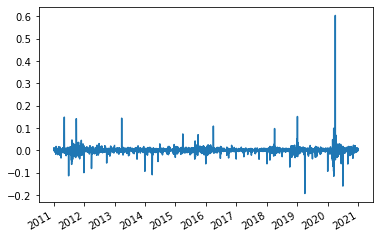

In [26]:
#plot the return
pf['return'].plot()

In [27]:
dow = pd.read_csv('DOW.csv')
dia = pd.read_csv('DIA.csv')
spy = pd.read_csv('SPY.csv')

<AxesSubplot:>

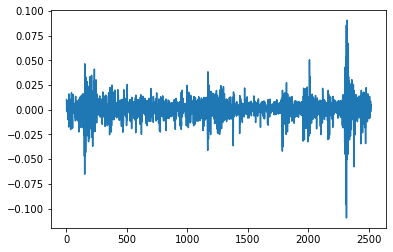

In [28]:
dow['mkval'] = dow['cshoc']*dow['prccd']
dow['returns'] = (dow['prccd']-dow['prccd'].shift())/dow['prccd'].shift()
dow['datadate'] = pd.to_datetime(dow['datadate'])


dia['mkval'] = dia['cshoc']*dia['prccd']
dia['returns'] = (dia['prccd']-dia['prccd'].shift())/dia['prccd'].shift()
dia['datadate'] = pd.to_datetime(dia['datadate'])

spy['mkval'] = spy['cshoc']*spy['prccd']
spy['returns'] = (spy['prccd']-spy['prccd'].shift())/spy['prccd'].shift()
spy['datadate'] = pd.to_datetime(spy['datadate'])
spy.set_index(['datadate'])
spy['returns'].plot()

# Where the dow starts

In [29]:
dow = dow.dropna()

here now we start to reballance baised on the share price not of the market value but everything is the same as above

In [30]:
last_date_dow = ['2010-12-31', '2011-12-30','2012-12-31','2013-12-31','2014-12-31','2015-12-31',\
             '2016-12-30','2017-12-29','2018-12-31','2019-12-31','2020-12-31']
stock_invest_dow = pd.DataFrame()
for i in last_date_dow:
    stock_invest_dow.loc[:,last_date_dow.index(i)] = list(dow[dow["datadate"]== i].sort_values\
                                                    (by = "prccd", ascending = False)["tic"].head(27))
stock_invest_dow

,0,1,2,3,4,5,6,7,8,9,10
0,AAPL,AAPL,AAPL,AAPL,V,GS,GS,BA,BA,BA,UNH
1,GS,IBM,IBM,V,GS,AMGN,MMM,GS,UNH,UNH,HD
2,IBM,CVX,CRM,IBM,MMM,MMM,IBM,MMM,AMGN,AAPL,GS
3,CRM,V,V,GS,IBM,BA,UNH,UNH,MMM,AMGN,AMGN
4,CAT,CRM,GS,MMM,AMGN,IBM,BA,HD,MCD,GS,CRM
5,CVX,MCD,CVX,BA,BA,HD,AMGN,AMGN,HD,HD,MSFT
6,MMM,NKE,MMM,CVX,CVX,MCD,HD,MCD,GS,MCD,V
7,NKE,CAT,CAT,AMGN,AAPL,UNH,TRV,AAPL,AAPL,V,MCD
8,MCD,GS,MCD,MCD,TRV,TRV,MCD,CAT,CRM,HON,BA
9,V,MMM,AMGN,JNJ,HD,AAPL,CVX,IBM,HON,MMM,HON


weighted by price/sum of all prices

In [31]:
weighted_dow = pd.DataFrame()
for i in last_date:
    price = dow[dow['datadate'] == i].sort_values(by = "prccd", ascending = False)["prccd"].sum()
    weighted_dow.loc[:,last_date.index(i)] = list(dow[dow['datadate'] == i].sort_values\
                                                    (by = "prccd", ascending = False)["prccd"].head(27)/price)
weighted_dow

,0,1,2,3,4,5,6,7,8,9,10
0,0.158725,0.176992,0.199143,0.176920,0.085025,0.062577,0.073815,0.073746,0.083028,0.068292,0.071996
1,0.082748,0.080359,0.071680,0.070223,0.062854,0.056362,0.055048,0.063706,0.064136,0.061630,0.054533
2,0.072218,0.046499,0.062904,0.059151,0.053285,0.052303,0.051170,0.058857,0.050118,0.061561,0.054141
3,0.064955,0.044370,0.056722,0.055900,0.052027,0.050203,0.049336,0.055129,0.049055,0.050538,0.047204
4,0.046088,0.044340,0.047734,0.044228,0.051654,0.047783,0.047992,0.047394,0.045715,0.048202,0.045686
5,0.044902,0.043846,0.040467,0.043043,0.042149,0.045918,0.045072,0.043486,0.044235,0.045781,0.045664
6,0.042467,0.042115,0.034745,0.039391,0.036377,0.041019,0.041333,0.043041,0.043007,0.041427,0.044906
7,0.042033,0.039594,0.033532,0.035976,0.035793,0.040845,0.037739,0.042318,0.040610,0.039391,0.044054
8,0.037772,0.039519,0.033009,0.030599,0.034324,0.039186,0.037523,0.039405,0.035263,0.037106,0.043947
9,0.034633,0.035717,0.032257,0.028883,0.034039,0.036547,0.036283,0.038365,0.034014,0.036985,0.043668


In [32]:
df2 = dow[dow["datadate"].isin(last_date_quarterly)]
df2

,gvkey,iid,datadate,tic,conm,cshoc,prccd,mkval,returns
62,1300,1,2011-03-31,HON,HONEYWELL INTERNATIONAL INC,7.850760e+08,59.71,4.687689e+10,0.002014
125,1300,1,2011-06-30,HON,HONEYWELL INTERNATIONAL INC,7.870080e+08,59.59,4.689781e+10,0.016547
189,1300,1,2011-09-30,HON,HONEYWELL INTERNATIONAL INC,7.824250e+08,43.91,3.435628e+10,-0.024222
252,1300,1,2011-12-30,HON,HONEYWELL INTERNATIONAL INC,7.734970e+08,54.35,4.203956e+10,-0.008031
314,1300,1,2012-03-30,HON,HONEYWELL INTERNATIONAL INC,7.762780e+08,61.05,4.739177e+10,0.005766
...,...,...,...,...,...,...,...,...,...
93100,179534,1,2019-12-31,V,VISA INC,1.711838e+09,187.90,3.216544e+11,0.000373
93162,179534,1,2020-03-31,V,VISA INC,1.706024e+09,161.12,2.748746e+11,-0.026877
93225,179534,1,2020-06-30,V,VISA INC,1.687112e+09,193.17,3.258994e+11,0.009353
93289,179534,1,2020-09-30,V,VISA INC,1.686007e+09,199.97,3.371508e+11,0.002657


In [33]:
def porfolio_fund(stock_list,weight_list,invest_fund,start_date,end_date):
    
    stock_fund = stock_cf(stock_list.iloc[0],weight_list.iloc[0],invest_fund,\
                          start_date,end_date).reset_index()["fund"]
    for i in range(len(stock_list)-1):
        stock_fund = stock_fund +stock_cf(stock_list.iloc[i+1],weight_list.iloc[i+1],\
                                    invest_fund,start_date,end_date).reset_index()["fund"]
    return stock_fund


def fund_flow_dow(stock,weighted,invest,start_date,end_date):
    initial_funds = (weighted*invest)
    total_value = initial_funds.map(lambda x : x / list(df2[(df2['datadate'] == start_date) &(df2["tic"] == \
                stock[list(initial_funds).index(x)])]["prccd"])[0] * list(dow[(dow['datadate'] == end_date) &(dow["tic"] ==\
                stock[list(initial_funds).index(x)])]["prccd"])[0]).sum()
    return total_value

def stock_cf_dow(stock,weight,invest_fund,start_date,end_date):
    stockx = dow[(dow["tic"] ==stock) &(dow["datadate"]>=start_date)&(dow["datadate"]<=end_date)][["datadate","prccd"]]
    shares = invest_fund*weight/stockx["prccd"].iloc[0]
    stockx["fund"] = shares*stockx["prccd"]
    return stockx["fund"]

In [34]:
porfolio_fund(stock_invest_dow.loc[:,0],weighted_dow.loc[:,0],funds_list[0],last_date_quarterly[0],last_date_quarterly[1])

0     9.900452e+05
1     1.003120e+06
2     1.003365e+06
3     1.011057e+06
4     1.009631e+06
          ...     
58    1.029569e+06
59    1.026794e+06
60    1.033014e+06
61    1.040100e+06
62    1.037210e+06
Name: fund, Length: 63, dtype: float64

In [35]:
start_fund_dow = 1000000
funds_list_dow = []
funds_list_dow.append(start_fund_dow)

for i in range(len(last_date_quarterly)-1):
    funds_list_dow.append(fund_flow_dow(stock_invest_dow[int(i/4)],weighted_dow[int(i/4)],funds_list_dow[i],last_date_quarterly[i],\
                                last_date_quarterly[i+1]))

In [36]:
stock_cf_dow(stock_invest_dow.loc[0,0],weighted_dow.loc[0,0],funds_list_dow[0],last_date_quarterly[0],last_date_quarterly[1])

7564    158725.316038
7565    162174.796648
7566    163021.174201
7567    164354.710928
7568    164221.849335
            ...      
7622    172985.793651
7623    172444.505681
7624    172700.387267
7625    171553.840930
7626    171493.561134
Name: fund, Length: 63, dtype: float64

In [37]:
porfolio_cf_dow = porfolio_fund(stock_invest_dow.loc[:,0],weighted_dow.loc[:,0],funds_list_dow[0],last_date_quarterly[0],last_date_quarterly[1])
for i in range(len(last_date_quarterly)-2):
    porfolio_cf_dow = pd.concat([porfolio_cf_dow,\
                            porfolio_fund(stock_invest_dow.loc[:,int(i/4)],weighted_dow.loc[:,int(i/4)],\
                            funds_list_dow[int(i/4)],last_date_quarterly[i+1],last_date_quarterly[i+2])]\
                            ,axis = 0)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [38]:
porfolio_cf_dow

0     9.900452e+05
1     1.003120e+06
2     1.003365e+06
3     1.011057e+06
4     1.009631e+06
          ...     
60    1.084589e+06
61    1.092954e+06
62    1.090257e+06
63    1.092800e+06
64    1.098684e+06
Name: fund, Length: 2557, dtype: float64

<AxesSubplot:>

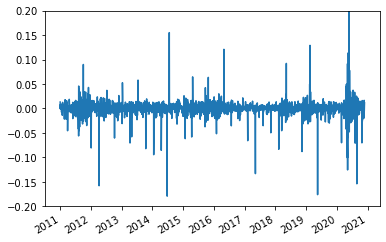

In [39]:
import matplotlib.pyplot as plt

pf_dow = pd.DataFrame()

pf_dow = pf_dow.reindex(dow[(last_date_quarterly[0]<=dow["datadate"])&\
                             (last_date_quarterly[-1]>dow["datadate"])]["datadate"].value_counts().sort_index().index)
porfolio_cf_dow = porfolio_cf_dow.head(2492)
pf_dow = pf_dow.head(2492)
pf_dow["cf"] = list(porfolio_cf_dow)
pf_dow["return"] = pf_dow["cf"] /pf_dow["cf"].shift()-1
plt.ylim([-.2,.2])
pf_dow['return'].plot()

<AxesSubplot:>

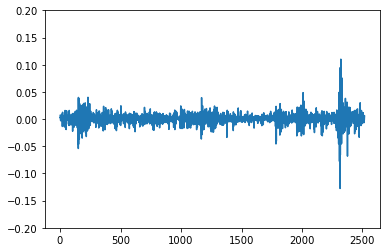

In [40]:

plt.ylim([-.2,.2])
dia['returns'].plot()


In [41]:
dia

,gvkey,iid,datadate,tic,conm,cshoc,prccd,mkval,returns
0,66311,1,2010-12-31,DIA,SPDR DJIA ETF TRUST,73990000.0,115.63,8.555464e+09,NaN
1,66311,1,2011-01-03,DIA,SPDR DJIA ETF TRUST,73990000.0,116.41,8.613176e+09,0.006746
2,66311,1,2011-01-04,DIA,SPDR DJIA ETF TRUST,75490000.0,116.64,8.805154e+09,0.001976
3,66311,1,2011-01-05,DIA,SPDR DJIA ETF TRUST,75240000.0,117.04,8.806090e+09,0.003429
4,66311,1,2011-01-06,DIA,SPDR DJIA ETF TRUST,73140000.0,116.78,8.541289e+09,-0.002221
...,...,...,...,...,...,...,...,...,...
2513,66311,1,2020-12-24,DIA,SPDR DJIA ETF TRUST,80443000.0,302.02,2.429539e+10,0.002456
2514,66311,1,2020-12-28,DIA,SPDR DJIA ETF TRUST,79993000.0,304.00,2.431787e+10,0.006556
2515,66311,1,2020-12-29,DIA,SPDR DJIA ETF TRUST,79643000.0,303.46,2.416846e+10,-0.001776
2516,66311,1,2020-12-30,DIA,SPDR DJIA ETF TRUST,79293000.0,304.13,2.411538e+10,0.002208


Create a copy of pf that will be used to store the percentage of returns for all indices

In [123]:
all_returns = pf.copy()

Change the index of the spy so that it can match the index of our all_returns df

In [124]:
spy_date_index = spy.copy()

spy_date_index.set_index('datadate', inplace = True)
spy_date_index

,gvkey,iid,tic,conm,cshoc,prccd,mkval,returns
datadate,,,,,,,,
2010-12-31,108132,1,SPY,SPDR S&P 500 ETF TRUST,723380000.0,125.75,9.096504e+10,NaN
2011-01-03,108132,1,SPY,SPDR S&P 500 ETF TRUST,715030000.0,127.05,9.084456e+10,0.010338
2011-01-04,108132,1,SPY,SPDR S&P 500 ETF TRUST,715030000.0,126.98,9.079451e+10,-0.000551
2011-01-05,108132,1,SPY,SPDR S&P 500 ETF TRUST,723930000.0,127.64,9.240243e+10,0.005198
2011-01-06,108132,1,SPY,SPDR S&P 500 ETF TRUST,743630000.0,127.39,9.473103e+10,-0.001959
...,...,...,...,...,...,...,...,...
2020-12-24,108132,1,SPY,SPDR S&P 500 ETF TRUST,885682000.0,369.00,3.268167e+11,0.003890
2020-12-28,108132,1,SPY,SPDR S&P 500 ETF TRUST,880782000.0,372.17,3.278006e+11,0.008591
2020-12-29,108132,1,SPY,SPDR S&P 500 ETF TRUST,880632000.0,371.46,3.271196e+11,-0.001908


Add the returns of the SPY to the DF

In [125]:
all_returns['SPY Return'] = spy_date_index['returns']
all_returns

,cf,return,SPY Return
2010-12-31,1.006406e+06,NaN,NaN
2011-01-03,1.017432e+06,0.010956,0.010338
2011-01-04,1.019203e+06,0.001741,-0.000551
2011-01-05,1.023850e+06,0.004559,0.005198
2011-01-06,1.021781e+06,-0.002021,-0.001959
...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899
2020-12-24,1.983465e+06,0.010349,0.003890
2020-12-28,1.981381e+06,-0.001051,0.008591
2020-12-29,1.979847e+06,-0.000774,-0.001908


In [126]:
dia_date_index = spy.copy()

dia_date_index.set_index('datadate', inplace = True)
dia_date_index

,gvkey,iid,tic,conm,cshoc,prccd,mkval,returns
datadate,,,,,,,,
2010-12-31,108132,1,SPY,SPDR S&P 500 ETF TRUST,723380000.0,125.75,9.096504e+10,NaN
2011-01-03,108132,1,SPY,SPDR S&P 500 ETF TRUST,715030000.0,127.05,9.084456e+10,0.010338
2011-01-04,108132,1,SPY,SPDR S&P 500 ETF TRUST,715030000.0,126.98,9.079451e+10,-0.000551
2011-01-05,108132,1,SPY,SPDR S&P 500 ETF TRUST,723930000.0,127.64,9.240243e+10,0.005198
2011-01-06,108132,1,SPY,SPDR S&P 500 ETF TRUST,743630000.0,127.39,9.473103e+10,-0.001959
...,...,...,...,...,...,...,...,...
2020-12-24,108132,1,SPY,SPDR S&P 500 ETF TRUST,885682000.0,369.00,3.268167e+11,0.003890
2020-12-28,108132,1,SPY,SPDR S&P 500 ETF TRUST,880782000.0,372.17,3.278006e+11,0.008591
2020-12-29,108132,1,SPY,SPDR S&P 500 ETF TRUST,880632000.0,371.46,3.271196e+11,-0.001908


Add the DIA returns to the DF

In [127]:
all_returns['DIA Return'] = dia_date_index['returns']
all_returns

,cf,return,SPY Return,DIA Return
2010-12-31,1.006406e+06,NaN,NaN,NaN
2011-01-03,1.017432e+06,0.010956,0.010338,0.010338
2011-01-04,1.019203e+06,0.001741,-0.000551,-0.000551
2011-01-05,1.023850e+06,0.004559,0.005198,0.005198
2011-01-06,1.021781e+06,-0.002021,-0.001959,-0.001959
...,...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899,0.000899
2020-12-24,1.983465e+06,0.010349,0.003890,0.003890
2020-12-28,1.981381e+06,-0.001051,0.008591,0.008591
2020-12-29,1.979847e+06,-0.000774,-0.001908,-0.001908


In [128]:
#change column name for clarity 
all_returns.rename(columns={'return': 'SP PF Return'}, inplace = True)
all_returns

,cf,SP PF Return,SPY Return,DIA Return
2010-12-31,1.006406e+06,NaN,NaN,NaN
2011-01-03,1.017432e+06,0.010956,0.010338,0.010338
2011-01-04,1.019203e+06,0.001741,-0.000551,-0.000551
2011-01-05,1.023850e+06,0.004559,0.005198,0.005198
2011-01-06,1.021781e+06,-0.002021,-0.001959,-0.001959
...,...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899,0.000899
2020-12-24,1.983465e+06,0.010349,0.003890,0.003890
2020-12-28,1.981381e+06,-0.001051,0.008591,0.008591
2020-12-29,1.979847e+06,-0.000774,-0.001908,-0.001908


In [129]:
#new indices to be added
VOO = pd.read_csv('VOO.csv')
FSKAX = pd.read_csv('FSKAX.csv')
VOO

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-12-31,114.860001,115.139999,114.680000,115.139999,93.716858,145750
1,2011-01-03,115.940002,116.660004,115.900002,116.220001,94.595909,119200
2,2011-01-04,116.559998,116.559998,115.500000,116.120003,94.514519,108350
3,2011-01-05,115.860001,116.800003,115.720001,116.739998,95.019142,717750
4,2011-01-06,116.839996,116.919998,116.220001,116.540001,94.856369,72450
...,...,...,...,...,...,...,...
2512,2020-12-23,338.540009,339.750000,337.690002,337.809998,334.388367,3682200
2513,2020-12-24,338.369995,339.179993,337.769989,339.160004,335.724701,1447500
2514,2020-12-28,341.739990,342.459991,341.089996,342.109985,338.644836,2798800
2515,2020-12-29,343.630005,343.769989,340.869995,341.390015,337.932129,2555500


For loops that calculate the percent return

In [130]:
VOO['returns'] = ""
for i in range(0, len(VOO)-1):
    x = VOO.loc[i,'Close']
    y = VOO.loc[i+1, 'Close']
    VOO_returns = (y-x)/x
    VOO['returns'][i+1] = VOO_returns
VOO

<ipython-input-130-9c9731fd76e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VOO['returns'][i+1] = VOO_returns


,Date,Open,High,Low,Close,Adj Close,Volume,returns
0,2010-12-31,114.860001,115.139999,114.680000,115.139999,93.716858,145750,
1,2011-01-03,115.940002,116.660004,115.900002,116.220001,94.595909,119200,0.00938
2,2011-01-04,116.559998,116.559998,115.500000,116.120003,94.514519,108350,-0.00086
3,2011-01-05,115.860001,116.800003,115.720001,116.739998,95.019142,717750,0.005339
4,2011-01-06,116.839996,116.919998,116.220001,116.540001,94.856369,72450,-0.001713
...,...,...,...,...,...,...,...,...
2512,2020-12-23,338.540009,339.750000,337.690002,337.809998,334.388367,3682200,0.0008
2513,2020-12-24,338.369995,339.179993,337.769989,339.160004,335.724701,1447500,0.003996
2514,2020-12-28,341.739990,342.459991,341.089996,342.109985,338.644836,2798800,0.008698
2515,2020-12-29,343.630005,343.769989,340.869995,341.390015,337.932129,2555500,-0.002104


In [131]:
FSKAX['returns'] = ""
for i in range(0, len(FSKAX)-1):
    x = FSKAX.loc[i,'Close']
    y = FSKAX.loc[i+1, 'Close']
    FSKAX_returns = (y-x)/x
    FSKAX['returns'][i+1] = FSKAX_returns
FSKAX

<ipython-input-131-8fa621f72cb7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FSKAX['returns'][i+1] = FSKAX_returns


,Date,Open,High,Low,Close,Adj Close,Volume,returns
0,2011-09-09,33.560001,33.560001,33.560001,33.560001,27.437431,0,
1,2011-09-12,33.790001,33.790001,33.790001,33.790001,27.625465,0,0.006853
2,2011-09-13,34.150002,34.150002,34.150002,34.150002,27.919798,0,0.010654
3,2011-09-14,34.639999,34.639999,34.639999,34.639999,28.320398,0,0.014348
4,2011-09-15,35.209999,35.209999,35.209999,35.209999,28.786411,0,0.016455
...,...,...,...,...,...,...,...,...
2338,2020-12-23,106.510002,106.510002,106.510002,106.510002,106.388313,0,0.001034
2339,2020-12-24,106.790001,106.790001,106.790001,106.790001,106.667992,0,0.002629
2340,2020-12-28,107.339996,107.339996,107.339996,107.339996,107.217361,0,0.00515
2341,2020-12-29,106.919998,106.919998,106.919998,106.919998,106.797844,0,-0.003913


In [132]:
VOO.rename(columns={'Date': 'datadate'}, inplace = True)
FSKAX.rename(columns={'Date': 'datadate'}, inplace = True)


Make into a datetime object and set the index to the date columns can combine into all_returns

In [133]:
VOO['datadate'] = pd.to_datetime(VOO['datadate'])
FSKAX['datadate'] = pd.to_datetime(FSKAX['datadate'])
VOO['datadate']

0      2010-12-31
1      2011-01-03
2      2011-01-04
3      2011-01-05
4      2011-01-06
          ...    
2512   2020-12-23
2513   2020-12-24
2514   2020-12-28
2515   2020-12-29
2516   2020-12-30
Name: datadate, Length: 2517, dtype: datetime64[ns]

In [134]:
VOO.set_index('datadate', inplace = True)
FSKAX.set_index('datadate', inplace = True)

In [135]:
all_returns['VOO Return'] = VOO['returns']
all_returns['FSKAX Return'] = FSKAX['returns']
all_returns

,cf,SP PF Return,SPY Return,DIA Return,VOO Return,FSKAX Return
2010-12-31,1.006406e+06,NaN,NaN,NaN,,NaN
2011-01-03,1.017432e+06,0.010956,0.010338,0.010338,0.00938,NaN
2011-01-04,1.019203e+06,0.001741,-0.000551,-0.000551,-0.00086,NaN
2011-01-05,1.023850e+06,0.004559,0.005198,0.005198,0.005339,NaN
2011-01-06,1.021781e+06,-0.002021,-0.001959,-0.001959,-0.001713,NaN
...,...,...,...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899,0.000899,0.0008,0.001034
2020-12-24,1.983465e+06,0.010349,0.003890,0.003890,0.003996,0.002629
2020-12-28,1.981381e+06,-0.001051,0.008591,0.008591,0.008698,0.00515
2020-12-29,1.979847e+06,-0.000774,-0.001908,-0.001908,-0.002104,-0.003913


In [136]:
#new indices to be added, however these only give monthly data, which is problematic
dow_index = pd.read_csv('index.csv')
sp_index = pd.read_csv('spindex.csv')
sp_index

,gvkeyx,prccm,datadate,tic
0,2,1390.360,01/31/2010,I0002
1,2,1429.910,02/28/2010,I0002
2,2,1506.910,03/31/2010,I0002
3,2,1527.790,04/30/2010,I0002
4,2,1404.050,05/31/2010,I0002
...,...,...,...,...
136,2,5813.129,05/31/2021,I0002
137,2,6005.973,06/30/2021,I0002
138,2,6166.906,07/31/2021,I0002
139,2,6331.508,08/31/2021,I0002


In [137]:
#all_returns['Dow_i_Return'] = dow_index['returns']
#all_returns['SP_i_Return'] = sp_index['returns']
#all_returns

In [138]:
#data has to be imported as monthly data will not give good results
#downloaded the daily returns of the actual S&P and Dow Jones Indices
import yfinance as yf
DJI = yf.download('^DJI', start='2010-12-31', end='2020-12-30')
GSPC = yf.download('^GSPC', start='2010-12-31', end='2020-12-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [139]:
DJI['returns'] = (DJI['Close']-DJI['Close'].shift())/DJI['Close'].shift()
DJI

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2010-12-31,11569.330078,11597.410156,11530.320312,11577.509766,11577.509766,93330000,NaN
2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,11670.750000,203420000,0.008054
2011-01-04,11670.900391,11698.219727,11635.740234,11691.179688,11691.179688,178630000,0.001751
2011-01-05,11688.610352,11742.679688,11652.889648,11722.889648,11722.889648,169990000,0.002712
2011-01-06,11716.929688,11736.740234,11667.459961,11697.309570,11697.309570,193080000,-0.002182
...,...,...,...,...,...,...,...
2020-12-22,30200.199219,30200.199219,29992.890625,30015.509766,30015.509766,388810000,-0.006650
2020-12-23,30046.730469,30292.529297,30046.730469,30129.830078,30129.830078,274050000,0.003809
2020-12-24,30155.919922,30209.669922,30099.300781,30199.869141,30199.869141,145570000,0.002325


Calculate the returns without a for loop due to the datetime object

In [140]:
GSPC['returns'] = (GSPC['Close']-GSPC['Close'].shift())/GSPC['Close'].shift()
GSPC

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2010-12-31,1256.760010,1259.339966,1254.189941,1257.640015,1257.640015,1799770000,NaN
2011-01-03,1257.619995,1276.170044,1257.619995,1271.869995,1271.869995,4286670000,0.011315
2011-01-04,1272.949951,1274.119995,1262.660034,1270.199951,1270.199951,4796420000,-0.001313
2011-01-05,1268.780029,1277.630005,1265.359985,1276.560059,1276.560059,4764920000,0.005007
2011-01-06,1276.290039,1278.170044,1270.430054,1273.849976,1273.849976,4844100000,-0.002123
...,...,...,...,...,...,...,...
2020-12-22,3698.080078,3698.260010,3676.159912,3687.260010,3687.260010,4023940000,-0.002073
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000,0.000746
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000,0.003537


Final addition to the DF with all returns

In [141]:
all_returns['Dow_i_Return'] = DJI['returns']
all_returns['SP_i_Return'] = GSPC['returns']
all_returns

,cf,SP PF Return,SPY Return,DIA Return,VOO Return,FSKAX Return,Dow_i_Return,SP_i_Return
2010-12-31,1.006406e+06,NaN,NaN,NaN,,NaN,NaN,NaN
2011-01-03,1.017432e+06,0.010956,0.010338,0.010338,0.00938,NaN,0.008054,0.011315
2011-01-04,1.019203e+06,0.001741,-0.000551,-0.000551,-0.00086,NaN,0.001751,-0.001313
2011-01-05,1.023850e+06,0.004559,0.005198,0.005198,0.005339,NaN,0.002712,0.005007
2011-01-06,1.021781e+06,-0.002021,-0.001959,-0.001959,-0.001713,NaN,-0.002182,-0.002123
...,...,...,...,...,...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899,0.000899,0.0008,0.001034,0.003809,0.000746
2020-12-24,1.983465e+06,0.010349,0.003890,0.003890,0.003996,0.002629,0.002325,0.003537
2020-12-28,1.981381e+06,-0.001051,0.008591,0.008591,0.008698,0.00515,0.006758,0.008723
2020-12-29,1.979847e+06,-0.000774,-0.001908,-0.001908,-0.002104,-0.003913,-0.002246,-0.002227


In [142]:
all_returns['Dow PF Return'] = pf_dow['return']
all_returns

,cf,SP PF Return,SPY Return,DIA Return,VOO Return,FSKAX Return,Dow_i_Return,SP_i_Return,Dow PF Return
2010-12-31,1.006406e+06,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
2011-01-03,1.017432e+06,0.010956,0.010338,0.010338,0.00938,NaN,0.008054,0.011315,0.013206
2011-01-04,1.019203e+06,0.001741,-0.000551,-0.000551,-0.00086,NaN,0.001751,-0.001313,0.000244
2011-01-05,1.023850e+06,0.004559,0.005198,0.005198,0.005339,NaN,0.002712,0.005007,0.007667
2011-01-06,1.021781e+06,-0.002021,-0.001959,-0.001959,-0.001713,NaN,-0.002182,-0.002123,-0.001410
...,...,...,...,...,...,...,...,...,...
2020-12-23,1.963148e+06,0.002202,0.000899,0.000899,0.0008,0.001034,0.003809,0.000746,NaN
2020-12-24,1.983465e+06,0.010349,0.003890,0.003890,0.003996,0.002629,0.002325,0.003537,NaN
2020-12-28,1.981381e+06,-0.001051,0.008591,0.008591,0.008698,0.00515,0.006758,0.008723,NaN
2020-12-29,1.979847e+06,-0.000774,-0.001908,-0.001908,-0.002104,-0.003913,-0.002246,-0.002227,NaN


In [143]:
#cleaning up the DF
all_returns = all_returns.iloc[1:,1:]
all_returns

,SP PF Return,SPY Return,DIA Return,VOO Return,FSKAX Return,Dow_i_Return,SP_i_Return,Dow PF Return
2011-01-03,0.010956,0.010338,0.010338,0.00938,NaN,0.008054,0.011315,0.013206
2011-01-04,0.001741,-0.000551,-0.000551,-0.00086,NaN,0.001751,-0.001313,0.000244
2011-01-05,0.004559,0.005198,0.005198,0.005339,NaN,0.002712,0.005007,0.007667
2011-01-06,-0.002021,-0.001959,-0.001959,-0.001713,NaN,-0.002182,-0.002123,-0.001410
2011-01-07,-0.002461,-0.001962,-0.001962,-0.002059,NaN,-0.001928,-0.001845,-0.001528
...,...,...,...,...,...,...,...,...
2020-12-23,0.002202,0.000899,0.000899,0.0008,0.001034,0.003809,0.000746,NaN
2020-12-24,0.010349,0.003890,0.003890,0.003996,0.002629,0.002325,0.003537,NaN
2020-12-28,-0.001051,0.008591,0.008591,0.008698,0.00515,0.006758,0.008723,NaN
2020-12-29,-0.000774,-0.001908,-0.001908,-0.002104,-0.003913,-0.002246,-0.002227,NaN


The tracking error is calculated for all indices in respect to our two portfolios, except for the FSKAX, which is missing data

In [144]:
all_returns['SP PF - SPY'] = all_returns['SP PF Return'] - all_returns['SPY Return']
np.std(all_returns['SP PF - SPY'])

0.022210834747798624

In [145]:
all_returns['SP PF - VOO'] = all_returns['SP PF Return'] - all_returns['VOO Return']
np.std(all_returns['SP PF - VOO'])

0.022288700213357455

In [114]:
all_returns['SP PF - SP_i'] = all_returns['SP PF Return'] - all_returns['SP_i_Return']
np.std(all_returns['SP PF - SPY'])

0.022210834747798624

In [115]:
all_returns['DOW PF - DIA'] = all_returns['Dow PF Return'] - all_returns['DIA Return']
np.std(all_returns['DOW PF - DIA'])

0.0195601407336396

In [116]:
all_returns['DOW PF - Dow_i'] = all_returns['Dow PF Return'] - all_returns['Dow_i_Return']
np.std(all_returns['DOW PF - Dow_i'])

0.019723373850188557

In [147]:
all_returns['SPY - SP_i'] = all_returns['SPY Return'] - all_returns['SP_i_Return']
np.std(all_returns['SPY - SP_i'])

0.0008768269469192592

In [120]:
all_returns.dropna(inplace = True)

<ipython-input-120-99d9954a97dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_returns.dropna(inplace = True)


In [121]:
all_returns = all_returns.iloc[1:,:]
all_returns

,SP PF Return,SPY Return,DIA Return,VOO Return,FSKAX Return,Dow_i_Return,SP_i_Return,Dow PF Return,SP - SPY,SP - VOO,SP PF - SP_i,SP PF - SPY,SP PF - VOO,DOW PF - DIA,DOW PF - Dow_i
2011-09-12,0.007137,0.006470,0.006470,0.00717,0.006853,0.006276,0.006966,-0.009791,0.000667,-0.000033,0.000171,0.000667,-0.000033,-0.016261,-0.016067
2011-09-13,0.012350,0.009171,0.009171,0.008243,0.010654,0.004044,0.009120,-0.023478,0.003179,0.004108,0.003230,0.003179,0.004108,-0.032649,-0.027522
2011-09-14,0.017789,0.013844,0.013844,0.014121,0.014348,0.012685,0.013480,0.008056,0.003945,0.003668,0.004310,0.003945,0.003668,-0.005788,-0.004629
2011-09-15,0.006637,0.017257,0.017257,0.017222,0.016455,0.016578,0.017187,0.008126,-0.010620,-0.010585,-0.010550,-0.010620,-0.010585,-0.009131,-0.008452
2011-09-16,-0.009314,0.000749,0.000749,0.005944,0.004828,0.006639,0.005707,0.013549,-0.010064,-0.015258,-0.015021,-0.010064,-0.015258,0.012800,0.006910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17,-0.004767,-0.005378,-0.005378,-0.004985,-0.002318,-0.005579,-0.004792,0.001116,0.000611,0.000218,0.000025,0.000611,0.000218,0.006494,0.006695
2020-11-18,-0.011618,-0.012035,-0.012035,-0.012133,-0.01007,-0.011581,-0.011564,0.014374,0.000417,0.000515,-0.000054,0.000417,0.000515,0.026409,0.025955
2020-11-19,0.004070,0.004210,0.004210,0.004185,0.005575,0.001522,0.003946,0.016618,-0.000140,-0.000115,0.000124,-0.000140,-0.000115,0.012408,0.015096
2020-11-20,-0.007681,-0.006848,-0.006848,-0.006693,-0.005447,-0.007453,-0.006793,-0.005308,-0.000833,-0.000988,-0.000888,-0.000833,-0.000988,0.001540,0.002145


Tracking error against the FSKAX is calculated aftering removing null values and cleaning the DF

In [122]:
all_returns['DOW PF - FSKAX'] = all_returns['Dow PF Return'] - all_returns['FSKAX Return']
np.std(all_returns['DOW PF - FSKAX'])

<ipython-input-122-9b7a17a359be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_returns['DOW PF - FSKAX'] = all_returns['Dow PF Return'] - all_returns['FSKAX Return']


0.02011186745446664